
--- Running model: Regression ---
Regression RMSE: 1.0056

--- Running model: ARIMA ---
ARIMA RMSE: 2.4785

--- Running model: Prophet ---


15:41:59 - cmdstanpy - INFO - Chain [1] start processing
15:41:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE: 2.2560

--- Running model: LSTM ---
LSTM RMSE: 9.9505

--- Running model: XGBoost ---
XGBoost RMSE: 2.8052

--- Running model: Ensemble ---
Ensemble RMSE: 1.0055

--- Running model: ClusterForecast ---
Error with ClusterForecast: 'RegressionModel' object is not callable


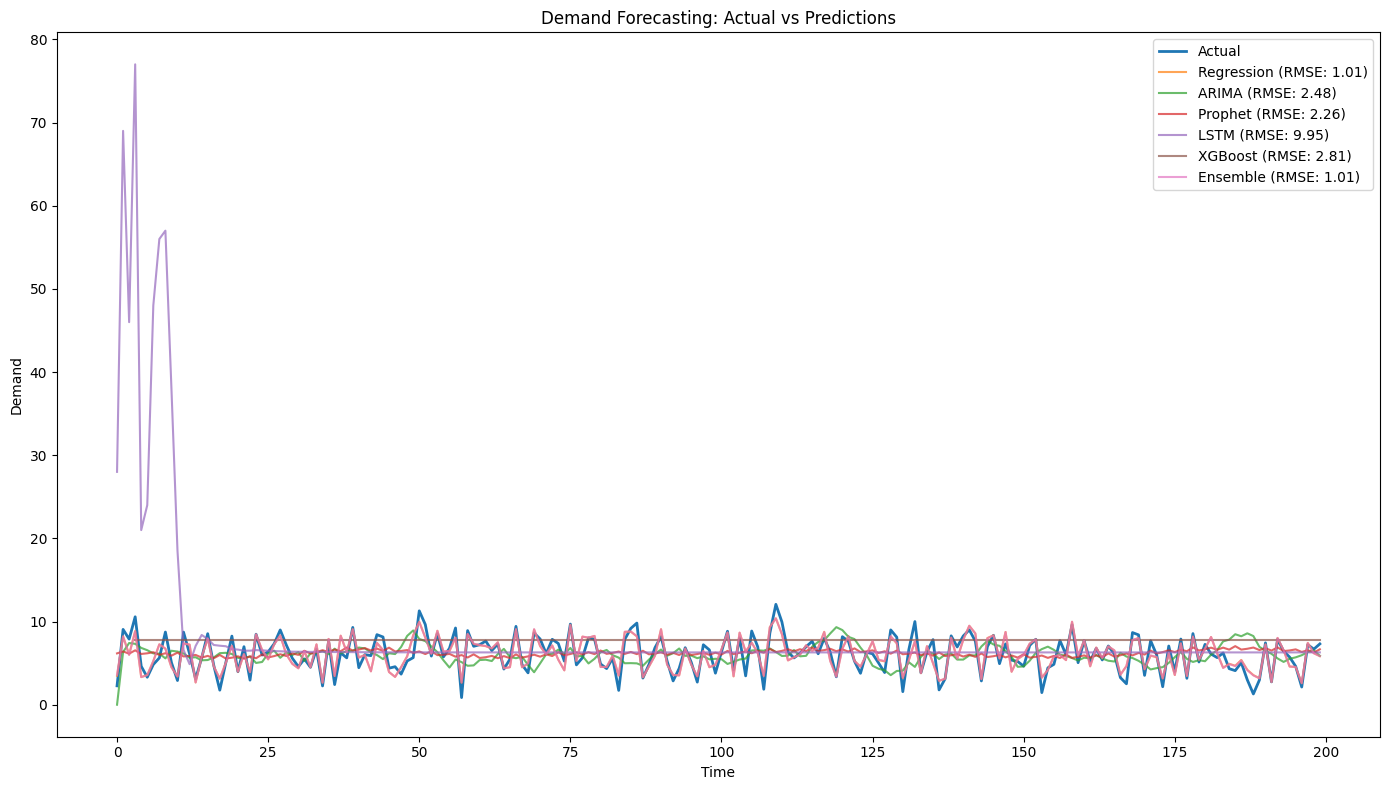

In [9]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Add project root to sys.path if running from subfolders
if "__file__" in globals():
    sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
else:
    # Fallback for Jupyter Notebook
    project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
    sys.path.append(project_root)

# Import modules
from data.data_generator import DataGenerator
from data.google_cluster_data import GoogleClusterData
from clustering.cluster_model import ClusterModel
from forecasting.regression_model import RegressionModel
from forecasting.arima_model import ARIMAModel
from forecasting.prophet_model import ProphetModel
from forecasting.lstm_model import LSTMModel
from forecasting.xgboost_model import XGBoostModel
from forecasting.ensemble_model import EnsembleModel
from forecasting.cluster_forecasting_model import ClusterForecastingModel
from utils.utils import calculate_rmse

# ------------------------------
# Load data
# ------------------------------
source = "synthetic"  # or "google"

if source == "synthetic":
    data = DataGenerator(n_samples=1000).generate()
else:
    data = GoogleClusterData("data/google_cluster_sample.csv").load_and_preprocess()

data.rename(columns={'y': 'demand'}, inplace=True)
features = [col for col in data.columns if col != 'demand']


# ------------------------------
# Train/Test split
# ------------------------------
train_size = int(0.8 * len(data))
train = data.iloc[:train_size]
test = data.iloc[train_size:]



# ------------------------------
# Clustering step
# ------------------------------
cluster_model = ClusterModel(n_clusters=4)
train = cluster_model.fit(train, features)
test = cluster_model.predict(test, features)

# Update features to include 'cluster'
features_with_cluster = features + ['cluster'] if 'cluster' not in features else features
# ------------------------------
# Initialize models
# ------------------------------
models = {
    "Regression": RegressionModel(),
    "ARIMA": ARIMAModel(),
    "Prophet": ProphetModel(),
    "LSTM": LSTMModel(epochs=5),
    "XGBoost": XGBoostModel(),
    "Ensemble": EnsembleModel([
        RegressionModel(), XGBoostModel(), ARIMAModel()
    ]),
    "ClusterForecast": ClusterForecastingModel(base_model_cls=RegressionModel(), cluster_model=cluster_model)  # Proposed method
}

results = {}

# ------------------------------
# Fit and evaluate models
# ------------------------------
for name, model in models.items():
    print(f"\n--- Running model: {name} ---")
    try:
        model.fit(train, features, 'demand')
        preds = model.predict(test, features)
        rmse = calculate_rmse(test['demand'], preds)
        results[name] = {"predictions": preds, "rmse": rmse}
        print(f"{name} RMSE: {rmse:.4f}")
    except Exception as e:
        print(f"Error with {name}: {e}")

# ------------------------------
# Plotting
# ------------------------------
plt.figure(figsize=(14, 8))
plt.plot(test['demand'].values, label='Actual', linewidth=2)

for name, res in results.items():
    plt.plot(res["predictions"], label=f'{name} (RMSE: {res["rmse"]:.2f})', alpha=0.7)

plt.legend()
plt.title("Demand Forecasting: Actual vs Predictions")
plt.xlabel("Time")
plt.ylabel("Demand")
plt.tight_layout()
plt.show()
